<a href="https://colab.research.google.com/github/claudiobarril/pln1_17co2024/blob/main/Desafio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
import os
import gdown
import json

from pathlib import Path

from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model, to_categorical

In [3]:
# Descargar la carpeta de dataset
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 241MB/s]


In [4]:
# dataset_file
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada línea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

Siguiendo las recomendaciones brindadas en la materia, se limitará a los intercambios en los que ambos interlocutores no usen más de 10 palabras.

In [6]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_words = 10

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

count_exceeds = 0
for line in data:
    for i in range(len(line['dialog'])-1):
        # separamos el texto en "preguntas" (chat_in) y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        # Medir por número de palabras
        if len(chat_in.split()) >= max_words or len(chat_out.split()) >= max_words:
            count_exceeds += 1
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

In [7]:
print("Cantidad de intercambios utilizados:", len(input_sentences))
print("Cantidad de intercambios descartados por longitud:", count_exceeds)

Cantidad de intercambios utilizados: 9092
Cantidad de intercambios descartados por longitud: 4420


In [8]:
# Ejemplo de las colecciones construidas
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [9]:
# Vocabulario máximo recomendado
MAX_VOCAB_SIZE = 8000

In [10]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario de entrada: 2724
Sentencia de entrada más larga: 9


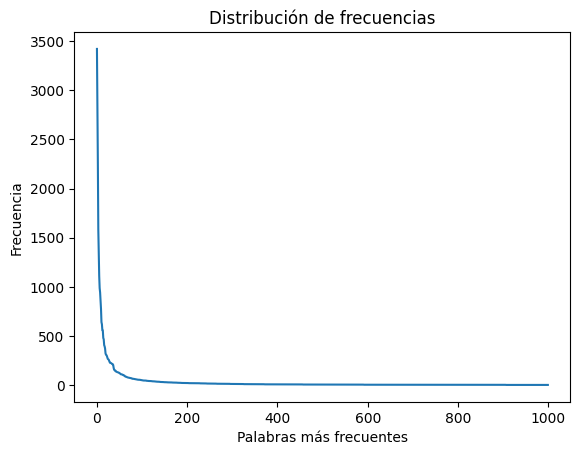

In [11]:
# Obtén el ranking de frecuencia
word_counts = input_tokenizer.word_counts
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Visualiza las 1000 más frecuentes
plt.plot([count for _, count in sorted_counts[:1000]])
plt.title("Distribución de frecuencias")
plt.xlabel("Palabras más frecuentes")
plt.ylabel("Frecuencia")
plt.show()

In [12]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de salida:", len(word2idx_outputs))

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

Palabras en el vocabulario de salida: 2731
Sentencia de salida más larga: 10


In [13]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [14]:
word2idx_inputs

{'i': 1,
 'you': 2,
 'do': 3,
 'what': 4,
 'a': 5,
 'am': 6,
 'to': 7,
 'is': 8,
 'are': 9,
 'like': 10,
 'how': 11,
 'for': 12,
 'have': 13,
 'love': 14,
 'that': 15,
 'hi': 16,
 'living': 17,
 'not': 18,
 'your': 19,
 'the': 20,
 'it': 21,
 'oh': 22,
 'my': 23,
 'of': 24,
 'good': 25,
 'about': 26,
 'in': 27,
 'any': 28,
 'yes': 29,
 'hello': 30,
 'ok': 31,
 'and': 32,
 'work': 33,
 'no': 34,
 'from': 35,
 'read': 36,
 'me': 37,
 'u': 38,
 'name': 39,
 'favorite': 40,
 'cool': 41,
 'play': 42,
 'hobbies': 43,
 'so': 44,
 'doing': 45,
 'well': 46,
 'where': 47,
 'today': 48,
 'too': 49,
 'go': 50,
 'great': 51,
 'music': 52,
 'with': 53,
 'see': 54,
 'know': 55,
 'nice': 56,
 'fun': 57,
 'there': 58,
 'at': 59,
 'fine': 60,
 'just': 61,
 'live': 62,
 'games': 63,
 'kind': 64,
 'hey': 65,
 'sure': 66,
 'can': 67,
 'why': 68,
 'lot': 69,
 'pets': 70,
 'thanks': 71,
 'sounds': 72,
 'also': 73,
 'bye': 74,
 'food': 75,
 'old': 76,
 'sorry': 77,
 'beach': 78,
 'job': 79,
 'okay': 80,
 'vid

In [15]:
word2idx_outputs

{'<eos>': 1,
 'i': 2,
 'you': 3,
 'do': 4,
 'what': 5,
 'a': 6,
 'am': 7,
 'to': 8,
 'is': 9,
 'are': 10,
 'like': 11,
 'how': 12,
 'for': 13,
 'have': 14,
 'love': 15,
 'that': 16,
 'living': 17,
 'not': 18,
 'your': 19,
 'the': 20,
 'it': 21,
 'good': 22,
 'my': 23,
 'oh': 24,
 'about': 25,
 'of': 26,
 'in': 27,
 'any': 28,
 'and': 29,
 'read': 30,
 'hello': 31,
 'work': 32,
 'yes': 33,
 'hi': 34,
 'from': 35,
 'me': 36,
 'no': 37,
 'u': 38,
 'doing': 39,
 'today': 40,
 'hobbies': 41,
 'name': 42,
 'ok': 43,
 'well': 44,
 'cool': 45,
 'favorite': 46,
 'play': 47,
 'so': 48,
 'where': 49,
 'too': 50,
 'go': 51,
 'great': 52,
 'see': 53,
 'fine': 54,
 'with': 55,
 'nice': 56,
 'music': 57,
 'fun': 58,
 'live': 59,
 'at': 60,
 'just': 61,
 'know': 62,
 'can': 63,
 'sure': 64,
 'kind': 65,
 'pets': 66,
 'there': 67,
 'why': 68,
 'games': 69,
 'thanks': 70,
 'lot': 71,
 'bye': 72,
 'old': 73,
 'job': 74,
 'beach': 75,
 'sounds': 76,
 'food': 77,
 'also': 78,
 'be': 79,
 'sorry': 80,
 'hey

In [16]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 9092
encoder_input_sequences shape: (9092, 9)
decoder_input_sequences shape: (9092, 10)


In [17]:
encoder_input_sequences

array([[   0,    0,    0, ...,    0,    0,   30],
       [   0,    0,    0, ...,   11,    9,    2],
       [   0,    0,    1, ...,   14,  457,  516],
       ...,
       [   1,   73,   13, ...,   10,  182,   49],
       [   0,    0,    0, ...,    3,   12,   17],
       [   0,    0,    0, ...,    2, 1010,    3]], dtype=int32)

In [18]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(9092, 10, 2732)

In [19]:
decoder_output_sequences

array([[ 34,  12,  10, ...,   0,   0,   0],
       [ 18, 238,  29, ...,   0,   0,   0],
       [ 36,  50,  29, ...,   1,   0,   0],
       ...,
       [  5,   4,   3, ...,   0,   0,   0],
       [  5,   4,   3, ...,   0,   0,   0],
       [  1,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [20]:
decoder_targets.shape

(9092, 10, 2732)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [21]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2025-04-24 18:49:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.15, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  21.1MB/s    in 58s     

2025-04-24 18:50:42 (21.9 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [22]:
!gunzip cc.en.300.vec.gz

In [23]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Diccionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

También de acuerdo a lo recomendado en la materia, se procede a utilizar embedding 300 Fasttext 300 para el embedding de entrada.

In [24]:
class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [25]:
model_embeddings = FasttextEmbeddings()

In [26]:
# Crear las Embedding matrix de las secuencias en inglés
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index proviene del tokenizer
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))
embedding_matrix_input = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)
    if embedding_vector is not None and len(embedding_vector) > 0:
        embedding_matrix_input[i] = embedding_vector[0]
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print("Cantidad de palabras no encontradas: {}".format(len(words_not_found)))

Cantidad de palabras no encontradas: 0


In [27]:
embedding_matrix_input

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.003     , -0.1437    , -0.1699    , ...,  0.56370002,
        -0.4456    , -0.2606    ],
       [ 0.2057    , -0.52499998,  0.31110001, ...,  0.78049999,
        -0.13259999,  0.0793    ],
       ...,
       [ 0.22050001, -0.57679999, -0.23370001, ...,  0.41010001,
        -0.1512    ,  0.1249    ],
       [ 0.0296    , -0.3039    , -0.3671    , ...,  0.36250001,
        -0.115     ,  0.0134    ],
       [ 0.0185    , -0.68599999, -0.1796    , ...,  0.64990002,
        -0.59329998, -0.1842    ]])

In [28]:
embedding_matrix_input.shape

(2724, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [47]:
n_units = 128

# ----- Encoder -----
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    weights=[embedding_matrix_input],
    trainable=False
)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# ----- Decoder -----
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_embedded  = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embedded , initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 9, 300)    │    817,200 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 10, 128)   │    349,696 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 128),     │    219,648 │ embedding_4[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 10, 128), │    131,584 │ embedding_5[0][0… │
│                     │ (None, 128),      │            │ lstm_4[0][1],     │
│                     │ (None, 128)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 2732)  │    352,428 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,870,556 (7.14 MB)

 Trainable params: 1,053,356 (4.02 MB)

 Non-trainable params: 817,200 (3.12 MB)

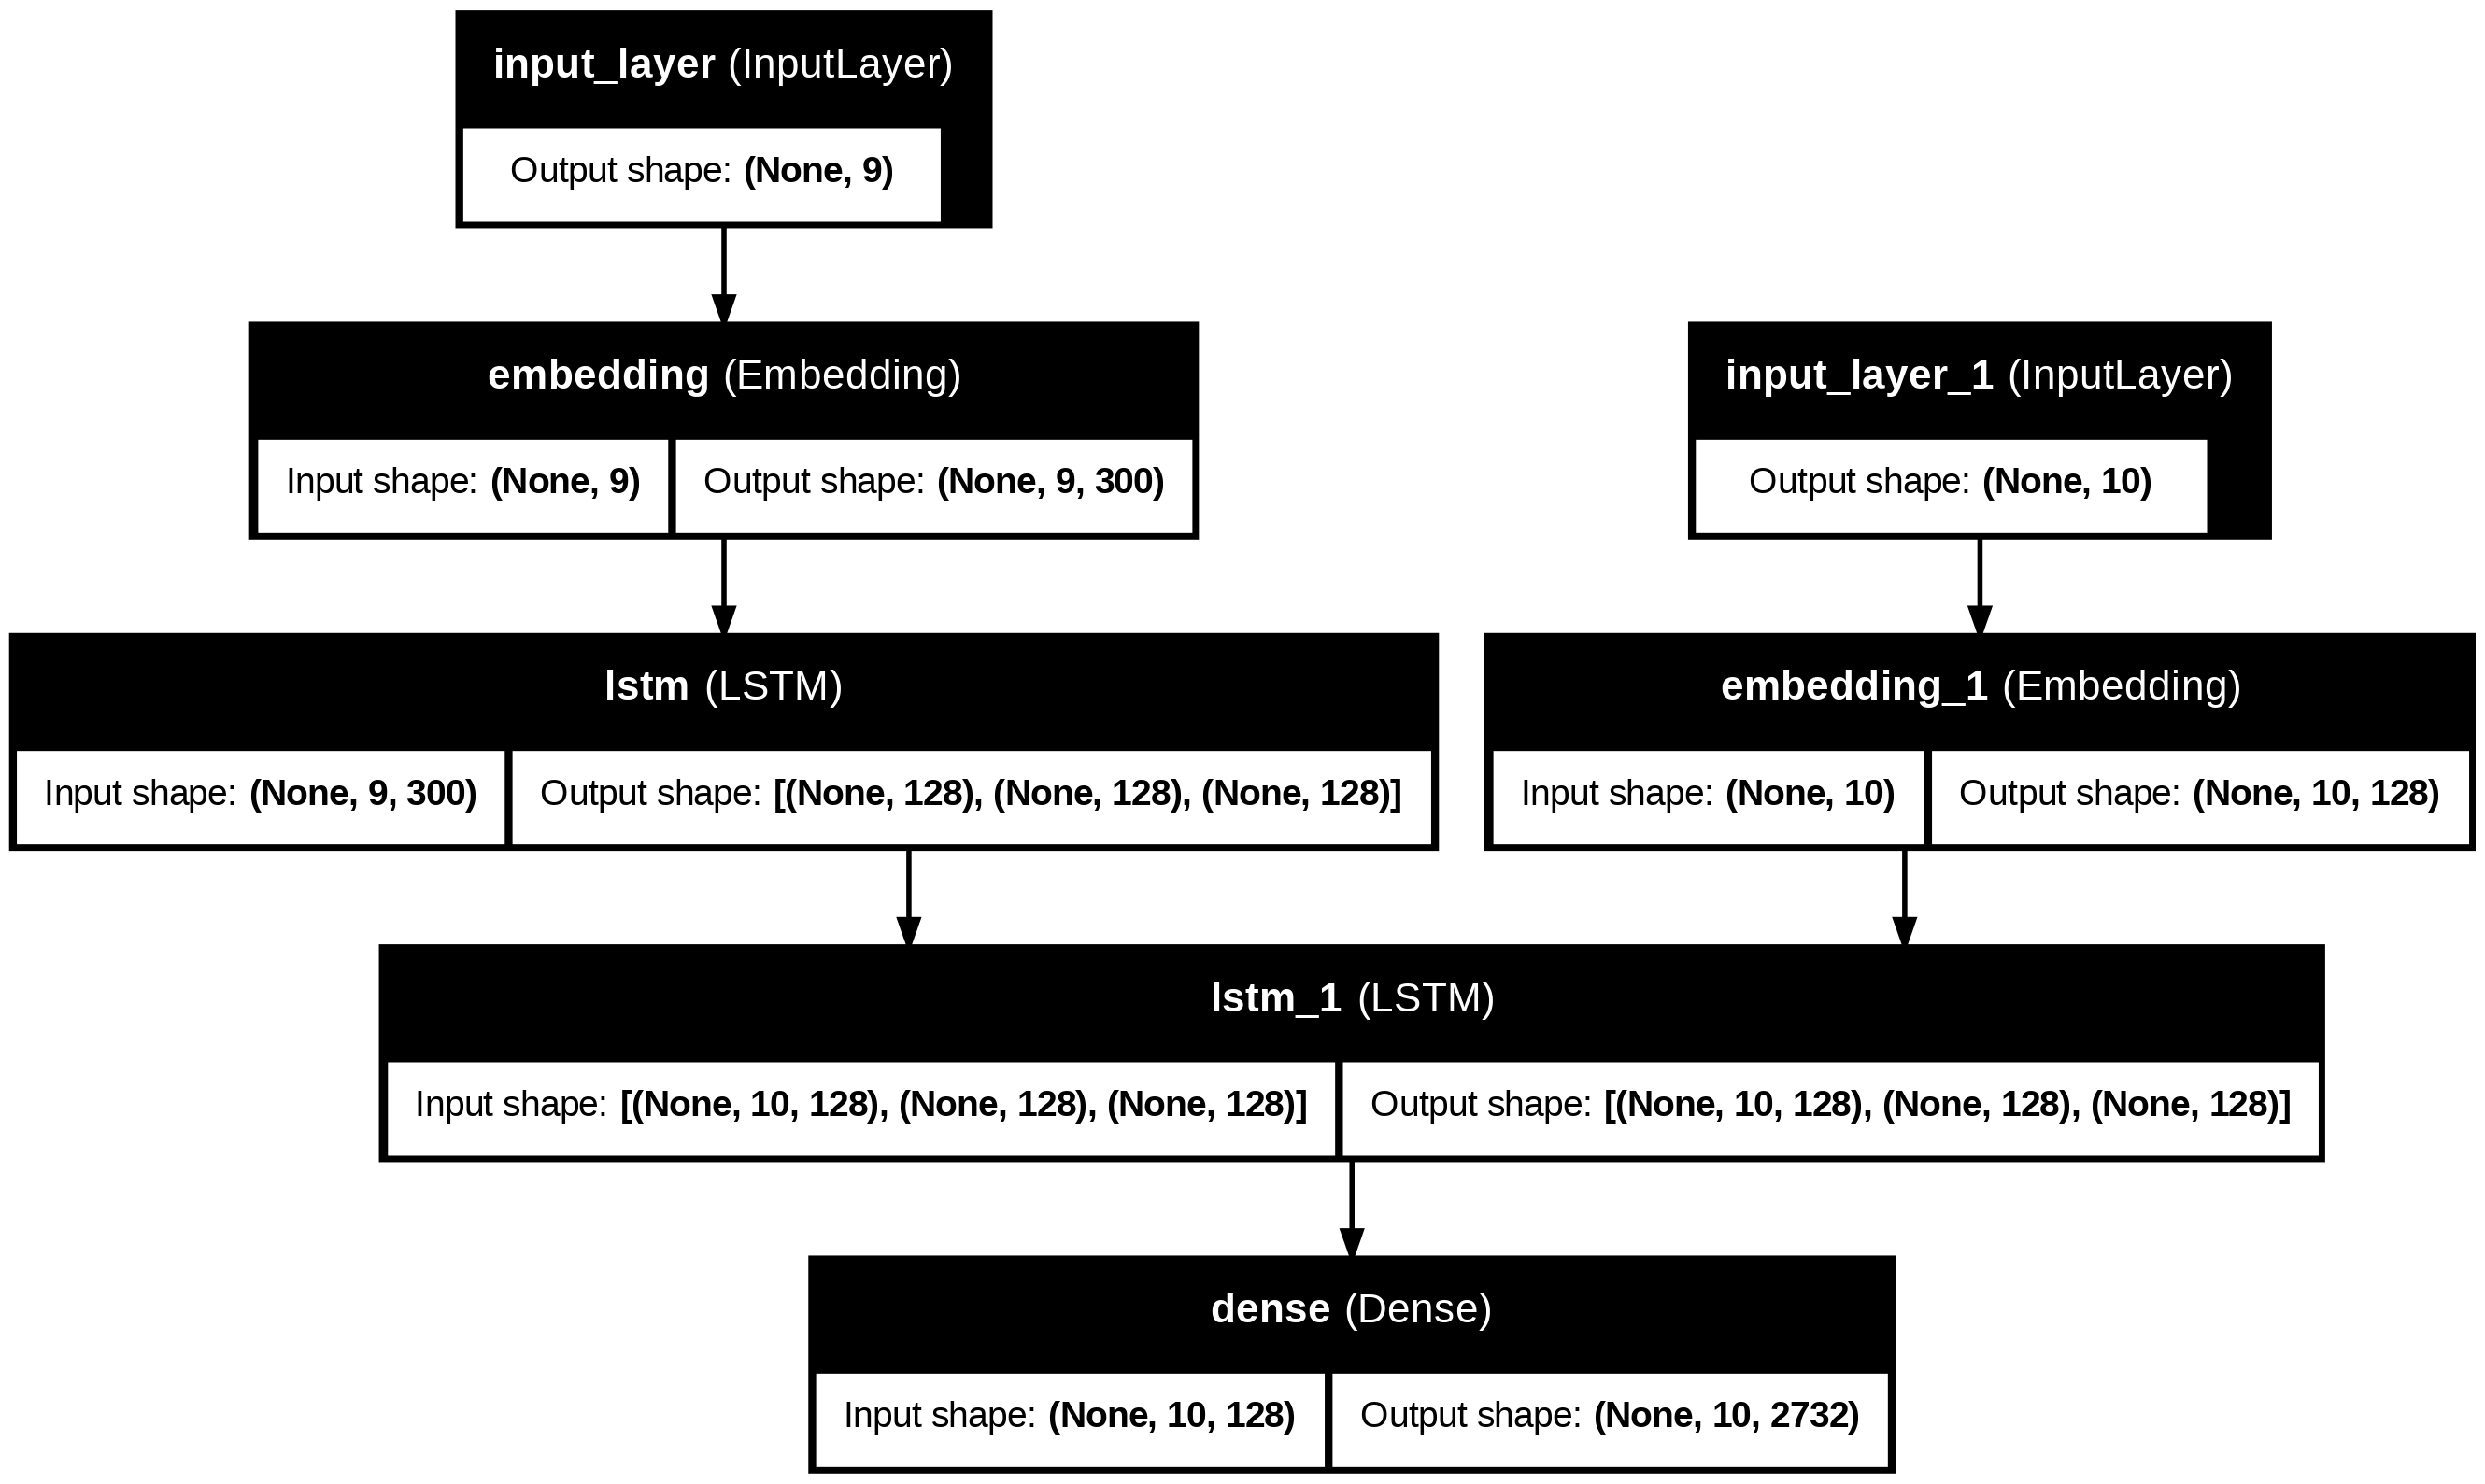

In [31]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

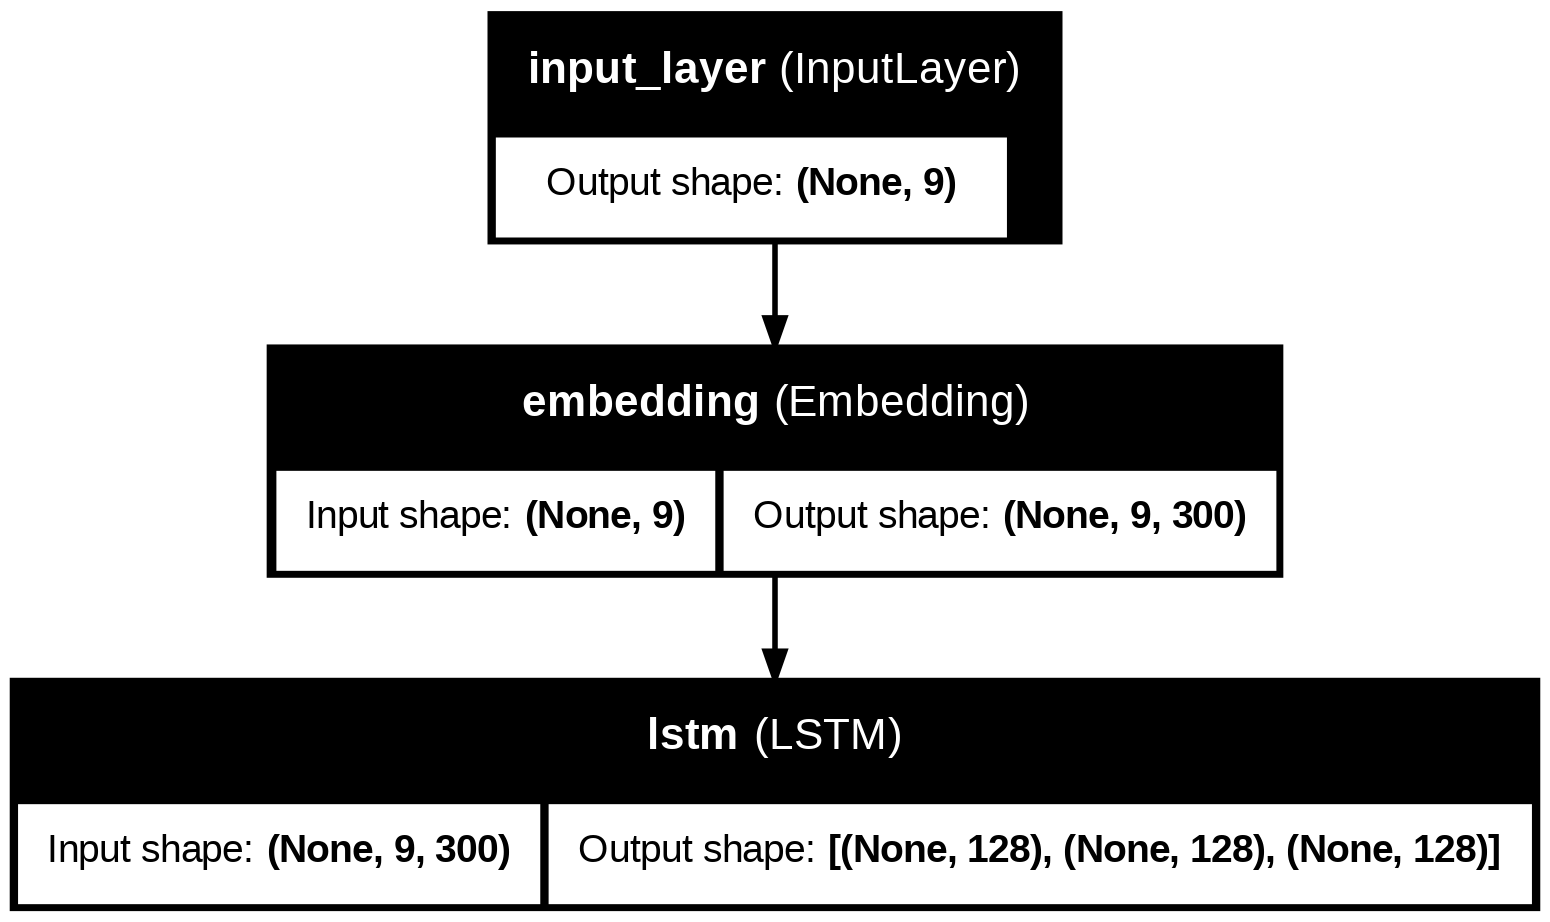

In [32]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

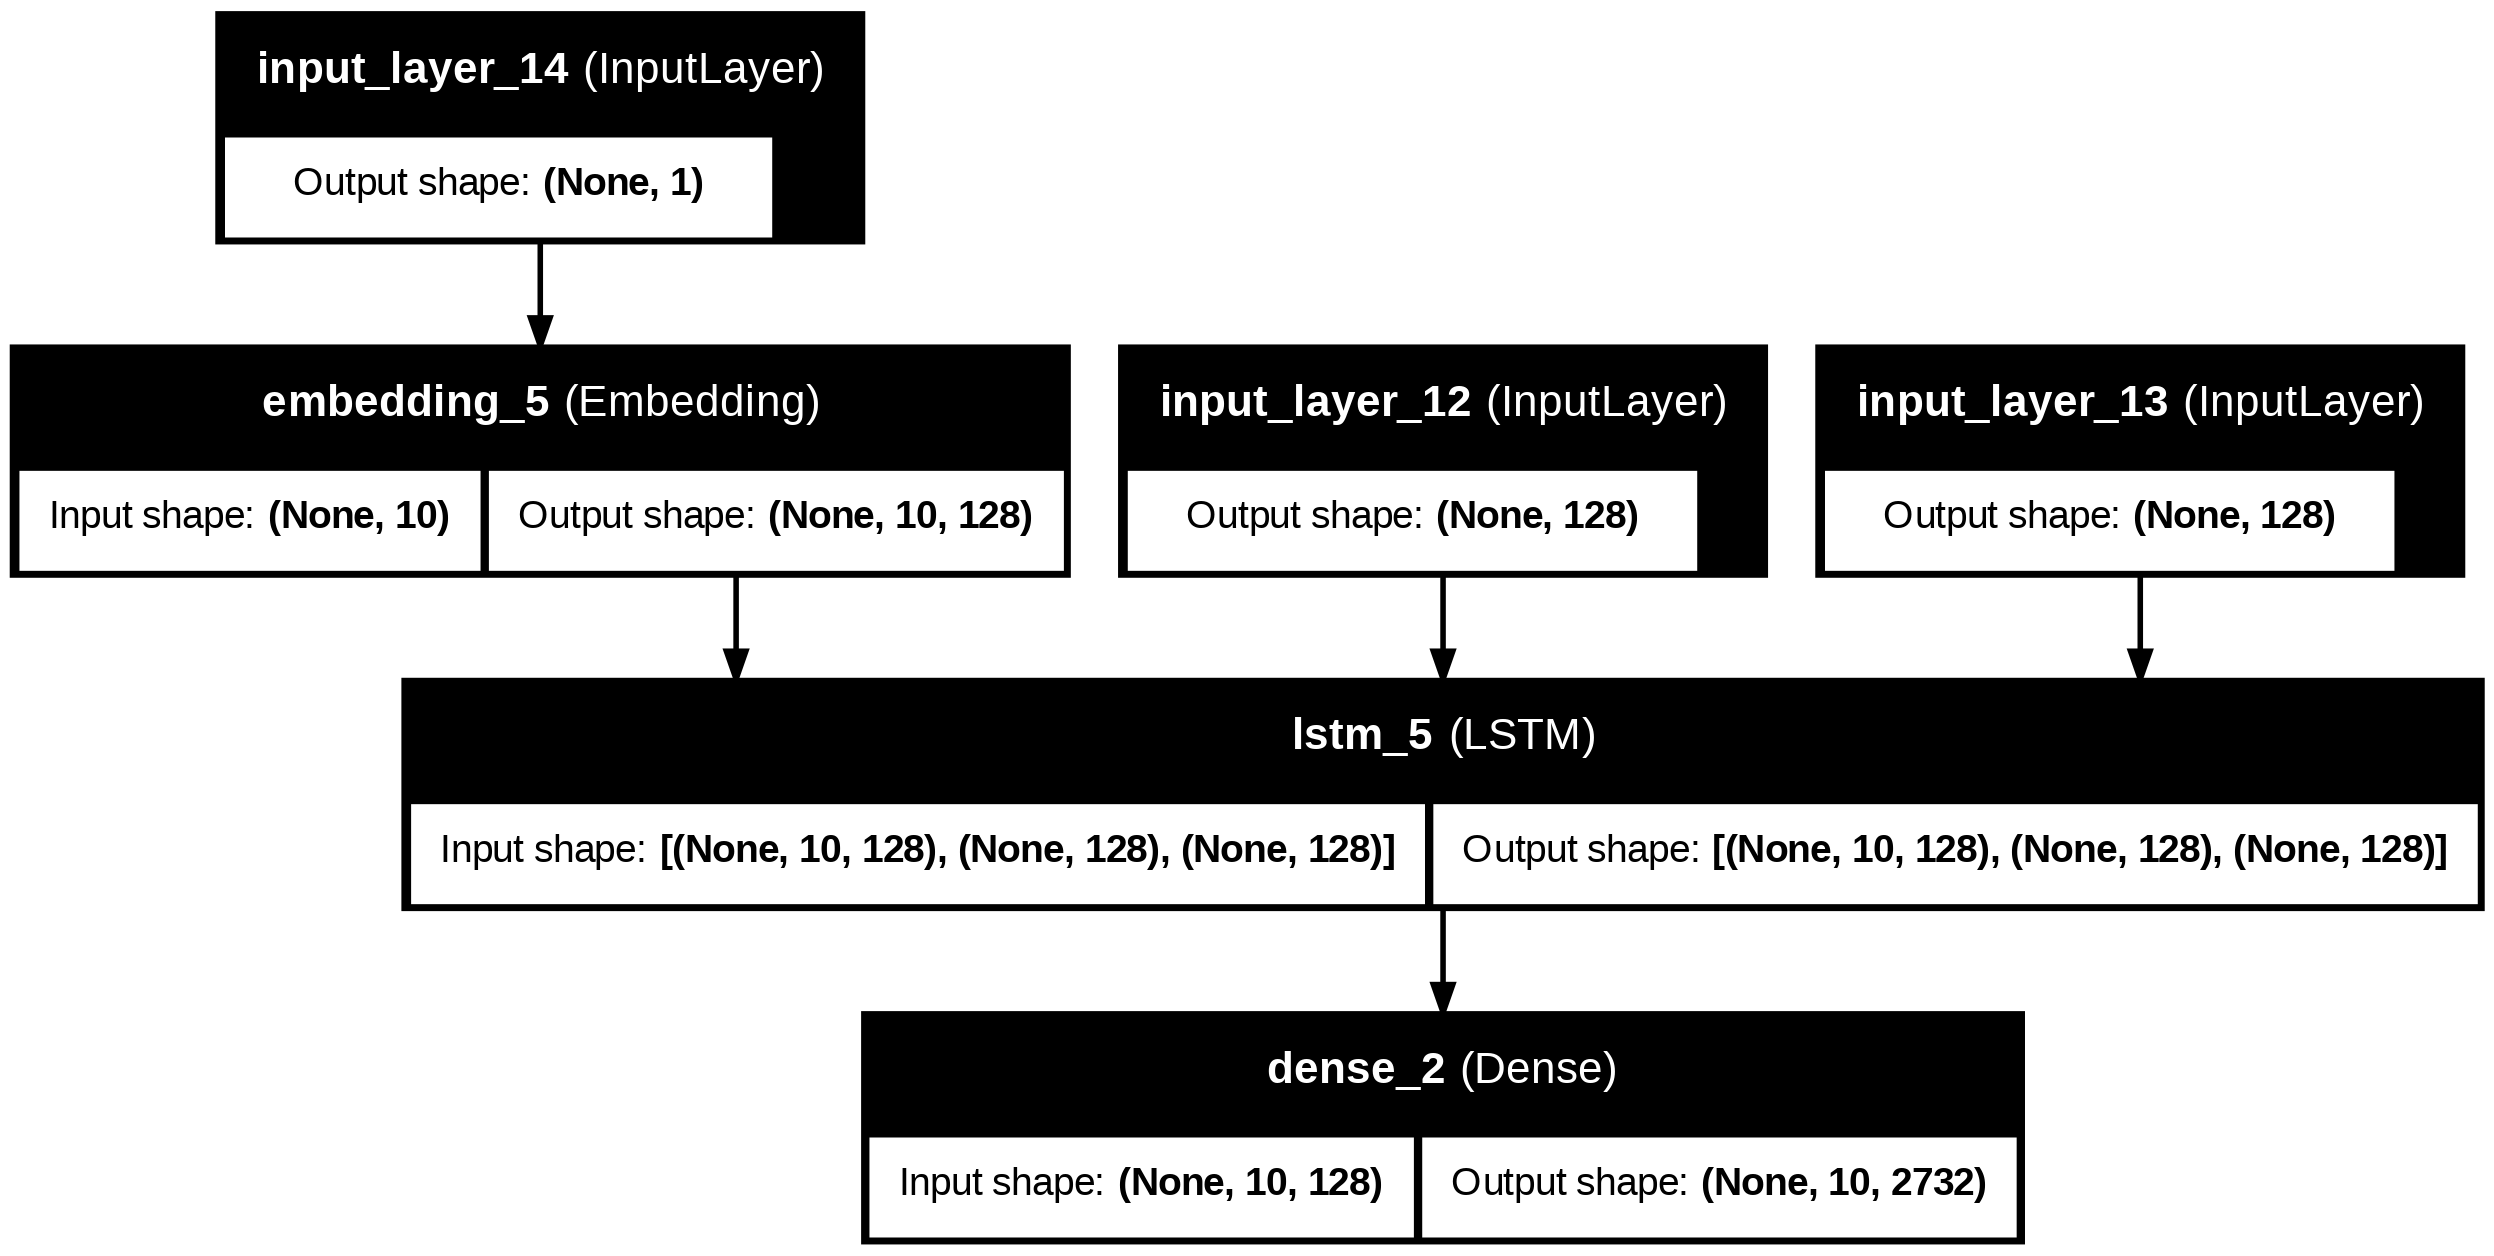

In [48]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

Se definen early stopper y model checkpoint, aunque finalmente no se utilizaron en la versión final.

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback para detener entrenamiento si no mejora la validación
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback para guardar el mejor modelo en formato .keras
model_checkpoint = ModelCheckpoint(
    filepath='best_chat_bot_model.keras',
    monitor='val_loss',
    save_best_only=True
)

# Entrenamiento con callbacks
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=40,
    validation_split=0.2,
)

Epoch 1/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.4408 - loss: 4.2481 - val_accuracy: 0.5706 - val_loss: 2.6081
Epoch 2/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.5684 - loss: 2.4762 - val_accuracy: 0.6205 - val_loss: 2.3879
Epoch 3/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.6293 - loss: 2.1956 - val_accuracy: 0.6386 - val_loss: 2.2376
Epoch 4/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.6449 - loss: 2.0253 - val_accuracy: 0.6510 - val_loss: 2.1494
Epoch 5/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.6644 - loss: 1.8954 - val_accuracy: 0.6620 - val_loss: 2.0910
Epoch 6/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6765 - loss: 1.7952 - val_accuracy: 0.6665 - val_loss: 2.0490
Epoch 7/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.6803 - loss: 1.7369 - val_accuracy: 0.6678 - val_loss: 2.0246
Epoch 8/40
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.6850 - loss: 1.6733 -

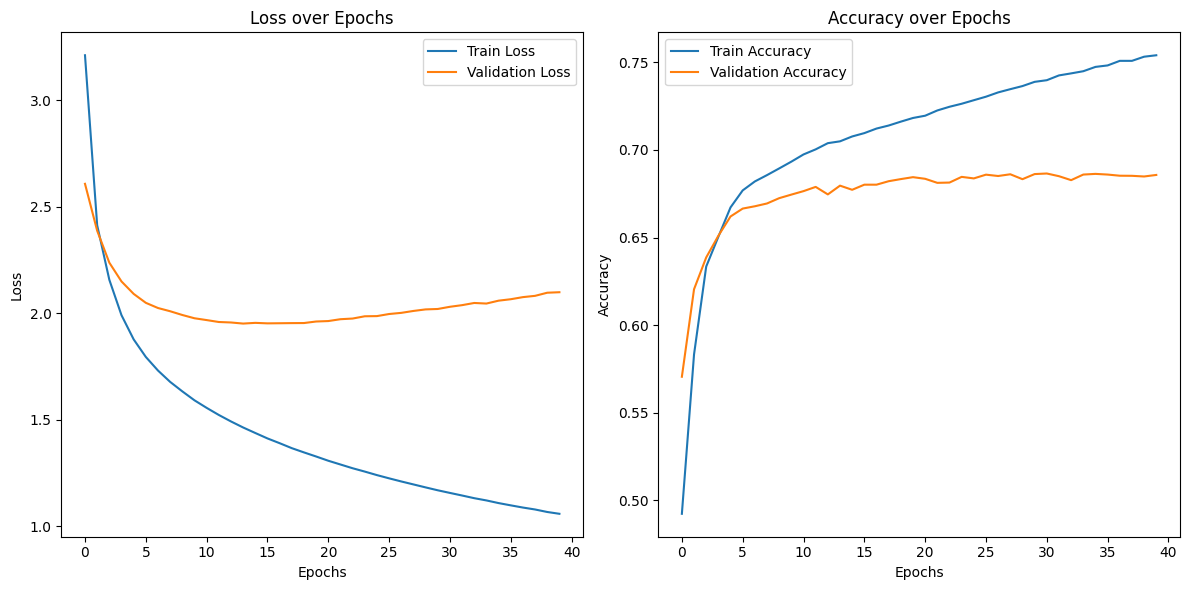

In [50]:
# Extract loss and accuracy values from history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Podemos ver que el val_loss empeora a partir de la época 20, y se va separando del train_loss, lo que indica overffiting. En contra parte, el accurancy de validación se estanca.

De todos modos, veamos la inferencia.

In [54]:
model.save("final_model.keras")

In [52]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('hello ', 'hi how are you  <eos>', '<sos> hi how are you ')

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [53]:
# Lista de frases para probar
test_sentences = [
    "Hi!",
    "Hello, how are you?",
    "What’s your name?",
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",
    "What can you do?",
    "Who created you?",
    "What is the capital of France?",
    "Can you help me?",
    "Tell me a joke.",
    "Bye!",
    "Thanks!"
]

# Función para tokenizar y obtener predicción
def predict_response(sentence, tokenizer_input, tokenizer_output, model, max_len=20):
    # Tokenizar entrada
    input_seq = tokenizer_input.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')  # Padding al tamaño máximo de entrada

    # Inicializar secuencia de salida con token <sos>
    output_seq = np.zeros((1, max_out_len))  # Definir una secuencia de salida vacía con la longitud máxima
    output_seq[0, 0] = tokenizer_output.word_index['<sos>']  # Asumimos que '<sos>' es el token de inicio

    # Predecir la secuencia
    for i in range(1, max_out_len):
        # Predecir la siguiente palabra
        pred = model.predict([input_seq, output_seq], verbose=0)

        # Obtener el token de la palabra predicha
        predicted_token = np.argmax(pred[0, i-1, :])  # Obtener el índice de la palabra con mayor probabilidad
        output_seq[0, i] = predicted_token  # Añadir el token a la secuencia de salida

        # Si el token predicho es <eos>, terminar la secuencia
        if predicted_token == tokenizer_output.word_index.get('<eos>', -1):
            break

    # Decodificar la secuencia resultante en texto
    response = tokenizer_output.sequences_to_texts(output_seq)[0]
    return response

# Probar cada oración
for sentence in test_sentences:
    response = predict_response(sentence, input_tokenizer, output_tokenizer, model)
    print(f"User: {sentence}")
    print(f"Bot:  {response}\n")

User: Hi!
Bot:  <sos> i love to read <eos>

User: Hello, how are you?
Bot:  <sos> i am a teacher i am a teacher <eos>

User: What’s your name?
Bot:  <sos> i love to read <eos>

User: Do you read?
Bot:  <sos> i am a teacher i am a teacher <eos>

User: Do you have any pet?
Bot:  <sos> i am a teacher what do you do <eos>

User: Where are you from?
Bot:  <sos> i am a teacher i am a teacher <eos>

User: What can you do?
Bot:  <sos> i am a teacher i am a teacher <eos>

User: Who created you?
Bot:  <sos> i love to read <eos>

User: What is the capital of France?
Bot:  <sos> i like to go to the beach <eos>

User: Can you help me?
Bot:  <sos> what do you do for a living <eos>

User: Tell me a joke.
Bot:  <sos> what do you do for a living <eos>

User: Bye!
Bot:  <sos> i love to read <eos>

User: Thanks!
Bot:  <sos> i love to read <eos>



Las inferencias no son satisfactorias. Se evidencian la repetición de ciertas respuestas y en ningún caso hacen sentido con la pregunta del interlocutor.
Se probaron tanto las preguntas propuestas en la materia como otras de distinta índole, pero en ningún caso se obtuvo una buena respuesta.

### Alternativas y Próximos pasos

Aunque no se reflejen en la notebook, se hicieron algunas pruebas, tanto con el early stopper y del model checkpoint instanciados, así como el entrenamiento con más interacciones extendiendo la longitud soportada, e incluso con algunas pequeñas modificaciones en el modelo.

Finalmente, y dado que los resultados fueron en todos los casos insatisfactorios, se dejó unicamente la versión final, a fin de disminuir el ruido.

Se considera, de todos modos, que sería interesante abarcar otras pruebas. Quedo abierto a recomendaciones en caso que el resultado sea mejorable.